<a id='home'></a>
### purpose

- retrieve common garden data for the time of growth for douglas-fir and jack pine
    - I have three sites for jack pine (Fontbrune, Petawa, and Ste-Christine de L'Auvergne - all established in 1966), but will probably only use two of them (Fontbrune, Ste-Christine.
    - I have one site for Douglas-fir (Vancouver) for seedlings over a two-year period (2018-2019)
    
### outline
[jack pine](#jack)
- [get elevation info for the jack pine common garden locations (needed for ClimateNA)](#elev)
    - note I don't end up using this variable in the revision
- [retrieve climate data from ClimateNA GUI](#ret)
- [average climate data for each of the three common gardens, for years 1966-2018 and 1975-1999](#avg)
- [determine which provenances in the common garden should represent the natural population data](#assign)
    - not all genotyped populations were in the common garden trials - determine distance between genotyped populations and planted provenances, keep only those unique pops/provs pairs with vincenty distances < 1km
    
[douglas-fir](#doug)
- read in two-year data from Tongli, subset envs, get two-year average
    - Tongli downloaded both years that our seedlings grew in the common garden, I need to take an average


### notes
- Tongli Wang retrieved the Vancouver common garden data for Douglas-fir climate 2018-2019
- I have data from Nathalie Isabel for three common garden trials - Fontbrune, Petawawa, and Ste-Christine de L'Auvergne (all established in 1966), though I probably won't use Petawawa.
- JP provenance 73 and 74 are both assigned to Marl Lake (data also from Nathalie Isabel). These have the same n_tree_alive and Mortality_2018 from the Team-LFC measurements, so I averaged the Mean_DBH2018 and Mean_Height_2018 and assigned these values to Prov 73, and I removed Prov 74 from the data before transferring to server - Prov 73 is in the genetic data, Prov 74 is not in the genetic data


### conclusions
- I was able to match 28 population and provenances by keeping only unique pairs with distance < 1km
- only 8 of these had provenances in Petawawa
- All of the Fontbrune pops are in Ste-Christine (27 pops), where Ste-Christine has one extra pop from the orange genetic group


In [1]:
from pythonimports import *
import xarray, rioxarray
from vincenty import vincenty

phenodir = '/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/phenotypes'

lview,dview = get_client()

latest_commit()
sinfo(html=True)

52 52
##################################################################
Current commit of pythonimports:
commit 20b1f40f7096065a45a44508a3d1c9ec81588a2e  
Author: Brandon <brandon.lind@ubc.ca>  
Date:   Wed Jun 30 11:47:39 2021 -0600
Today:	July 02, 2021 - 12:46:29
python version: 3.8.5
##################################################################



<a id='jack'></a>
# <center> jack pine </center>
    
[top](#home)

<a id='elev'></a>
## get elevation for common gardens

this is needed for ClimateNA - you'd think I could just give ClimateNA a lat/long and it could figure out elevation ...

### change projection to WGS84

In [2]:
def gdalwarp(netcdf_infile, netcdf_outfile, proj):
    """Convert netcdf_infile to WGS84 netcdf_outfile.

    Notes
    -----
    conda install -c conda-forge gdal 
    """
    import subprocess, shutil
    
    output = subprocess.check_output(['/lu213/brandon.lind/data/anaconda3/envs/gdal_env/bin/gdalwarp',
                                      '-s_srs', proj,
                                      '-t_srs',  '+proj=longlat +ellps=WGS84',
                                      '-of', 'netCDF',
                                      netcdf_infile,
                                      netcdf_outfile,
                                      '-overwrite']).decode('utf-8').split('\n')
    return output

In [3]:
# downloaded from 'reference files' (7unzipped manually, not shown)
# - https://adaptwest.databasin.org/pages/adaptwest-climatena
elefile = '/data/projects/pool_seq/environemental_data/netCDF_files/NA_Reference_files/ClimateNA_DEM.nc'

proj = '+proj=lcc +lat_1=49.0 +lat_2=77.0 +lat_0=0.0 +lon_0=-95.0 +x_0=0.0 +y_0=0.0 +ellps=WGS84 \
+datum=WGS84 +units=m +no_defs'

elefile84 = elefile.replace('.nc', '_WGS84.nc')

gdalwarp(elefile, elefile84, proj)

['Creating output file that is 15399P x 3236L.',
 'Processing /data/projects/pool_seq/environemental_data/netCDF_files/NA_Reference_files/ClimateNA_DEM.nc [1/1] : 0Using internal nodata values (e.g. -3.4e+38) for image /data/projects/pool_seq/environemental_data/netCDF_files/NA_Reference_files/ClimateNA_DEM.nc.',
 'Copying nodata values from source /data/projects/pool_seq/environemental_data/netCDF_files/NA_Reference_files/ClimateNA_DEM.nc to destination /data/projects/pool_seq/environemental_data/netCDF_files/NA_Reference_files/ClimateNA_DEM_WGS84.nc.',
 '...10...20...30...40...50...60...70...80...90...100 - done.',
 '']

### extract elevation data

In [4]:
# read in netcdf file
elefile84 = elefile.replace('.nc', '_WGS84.nc')
dataset = xarray.open_dataset(elefile84)
# add metadata for WGS84
dataset.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
dataset.rio.write_crs("epsg:4326", inplace=True)
dataset

<xarray.Dataset>
Dimensions:  (lat: 3236, lon: 15399)
Coordinates:
    crs      int64 0
  * lat      (lat) float64 8.128 8.151 8.175 8.198 ... 83.69 83.71 83.73 83.76
  * lon      (lon) float64 -180.0 -180.0 -179.9 -179.9 ... 179.9 180.0 180.0
Data variables:
    Band1    (lat, lon) float32 ...
Attributes:
    Conventions:   CF-1.5
    GDAL:          GDAL 3.2.2, released 2021/03/05
    history:       Fri Jul 02 12:46:30 2021: GDAL Create( /data/projects/pool...
    grid_mapping:  crs

In [5]:
# create objects with lat/long info
lats = pd.Series([46.963263, 46.807619, 45.58])
lons = pd.Series([-75.694855, -71.896128, -77.25])
target_lat = xarray.DataArray(lats, dims='points')
target_lon = xarray.DataArray(lons, dims='points')

# extract and convert to dataframe, label index with garden ID
df = dataset['Band1'].sel(lon=target_lon, lat=target_lat, method='nearest').to_dataframe()
df.index = ['fontbrune', 'st-christine', 'petawawa']
df

,crs,lat,lon,Band1
fontbrune,0,46.959018,-75.698440,247.0
st-christine,0,46.818749,-71.887803,156.0
petawawa,0,45.579708,-77.241397,182.0


<a id='ret'></a>
## get climate data for common garden

set lat/long/elevation
- fontbrune <- c(46.959018, -75.698440, 247.0)
- christine <- c(46.818749, -71.887803, 156.0)
- patawawa <- c(45.579708, -77.241397, 182.0)

using climateNA's time series function, retrieve data for these sites from 1966-2018
https://www.youtube.com/watch?v=_ESvTKHFbIg&t=9s

[top](#home)

<a id='avg'></a>
## calculate averages for each climate variable of interest for each garden

[top](#home)

In [6]:
# the envs I care about
envs = ['Elevation', 'AHM', 'CMD', 'DD5', 'DD_0', 'EMT', 'EXT', 'Eref', 'FFP', 'MAP', 'MAT', 'MCMT', 'MSP', 'MWMT',
        'NFFD', 'PAS', 'SHM', 'TD', 'bFFP', 'eFFP']
assert len(envs) == 20

In [7]:
# read in common garden data, reduce to only the needed columns
cgenvdata = pd.read_csv(op.join(phenodir, 'jack_pine_common_gardens_1966-2018MSY.csv'))
cgenvdata = cgenvdata[['Year', 'id2', 'Latitude', 'Longitude'] + envs]
cgenvdata.head()

,Year,id2,Latitude,Longitude,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP
0,1966,fontbrune,46.959018,-75.698440,247,14.4,155,1474,1261,-41.1,42.6,633,110,920,3.3,-13.7,449,17.8,125,311,39.5,31.5,149,258
1,1966,christine,46.818749,-71.887803,156,12.1,106,1577,1064,-38.9,43.6,625,119,1180,4.2,-10.9,576,18.4,140,397,32.0,29.3,144,263
2,1966,patawawa,45.579708,-77.241397,182,20.0,304,1821,1026,-37.3,46.1,705,121,755,5.1,-12.2,318,20.3,135,194,63.9,32.5,143,264
3,1967,fontbrune,46.959018,-75.698440,247,11.0,84,1507,1564,-41.1,42.6,616,113,1114,2.3,-17.5,528,18.0,125,369,34.1,35.6,148,261
4,1967,christine,46.818749,-71.887803,156,11.4,11,1652,1418,-38.9,43.6,599,124,1158,3.2,-15.6,577,19.4,136,352,33.6,35.0,143,267


In [8]:
def clean_data(data):
    """Get mean for each column in `data` for each garden ID in `id2`."""
    df = data.groupby(by='id2').mean().copy()  # average for each common garden
    df['Elevation'] = df['Elevation'].astype(int)  # float -> int
    df.pop('Year')  # avg year is meaningless
    df.index.name = None
    return df

In [9]:
# get averages for each garden for 1966-2018
avgcgdata = clean_data(cgenvdata)
avgcgdata

,Latitude,Longitude,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP
christine,46.818749,-71.887803,156,12.179245,77.132075,1739.150943,1281.716981,-38.9,43.6,621.962264,127.056604,1162.169811,3.998113,-13.845283,561.150943,18.962264,157.113208,358.075472,34.554717,32.811321,141.094340,268.169811
fontbrune,46.959018,-75.698440,247,13.962264,135.018868,1624.962264,1418.849057,-41.1,42.6,646.849057,116.056604,953.754717,3.237736,-15.224528,475.490566,18.154717,144.320755,298.849057,38.800000,33.377358,147.358491,263.471698
patawawa,45.579708,-77.241397,182,18.469811,219.283019,1975.150943,1065.811321,-37.3,46.1,709.264151,132.226415,844.339623,5.401887,-12.352830,399.660377,20.152830,160.849057,219.056604,51.871698,32.494340,138.320755,270.528302


In [10]:
# get averages for each garden for 1975-1999
bools = (cgenvdata['Year'] >= 1975) & (cgenvdata['Year'] <= 1999)
assert sum(bools)/3 == 25  # 25 years worth of data for 3 common gardens

subavgcgdata = clean_data(cgenvdata[bools])

subavgcgdata

,Latitude,Longitude,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP
christine,46.818749,-71.887803,156,12.032,82.28,1711.24,1322.68,-38.9,43.6,619.24,125.12,1156.60,3.796,-14.476,569.44,18.808,155.44,358.00,33.764,33.300,141.40,266.52
fontbrune,46.959018,-75.698440,247,13.908,144.76,1578.92,1479.84,-41.1,42.6,647.28,111.88,932.72,2.912,-15.976,463.88,17.992,141.48,301.28,39.596,33.968,149.00,260.84
patawawa,45.579708,-77.241397,182,18.812,240.72,1932.12,1099.88,-37.3,46.1,704.96,128.72,810.56,5.156,-12.964,377.52,20.056,157.76,219.40,54.432,33.008,139.48,268.32


In [11]:
# save 1966-2018
avgcgdata.to_csv(op.join(phenodir, 'jack_pine_common_gardens_average_climate_1966-2018.txt'),
                 sep='\t',
                 index=True)

In [12]:
# save 1975-1999
subavgcgdata.to_csv(op.join(phenodir, 'jack_pine_common_gardens_average_climate_1975-1999.txt'),
                    sep='\t',
                    index=True)

In [13]:
phenodir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/phenotypes'

<a id='assign'></a>
## assign provenance to population

- not all of our genotyped populations were in the provenance trials

[top](#home)

In [14]:
# lat long for each provenance in the common gardens
provdata = pd.read_csv(op.join(phenodir, 'DATA_Pinus_banksiana_ML2021-provenances.csv'))
print(nrow(provdata))
provdata.head()

96


,Provenance,Original_ID,Location,State,LAT,LONG
0,1,3201.0,Schoodic Head,ME,44.3500,-68.0500
1,2,3202.0,Birchtown brook,NS,43.8166,-65.3833
2,3,3203.0,Durell Island,NS,45.3353,-60.9997
3,4,3204.0,Cape Breton Highland Park,NS,46.7500,-60.3500
4,5,3205.0,Neil's Harbour,NS,46.8500,-60.3166


In [15]:
# get lat/long for each pop in our genetic data
envdata = pd.read_table('/data/projects/pool_seq/environemental_data/jp_rm_p24/jp_no-p24_raw_env-19variables.txt')
envdata.head()

,id1,id2,our_id,LAT,LONG,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP,group_color
0,9150251,38,JP_p98,54.3333,-106.6333,537,21.2,181,1273,2217,-46.0,34.7,534,103,461,-0.2,-20.1,305,16.6,149,129,54.4,36.7,148,251,green
1,3273,22,JP_p73,44.4200,-84.6800,359,22.0,241,1956,835,-34.1,36.6,745,131,732,6.1,-8.0,395,19.8,163,140,50.0,27.8,141,271,blue
2,8060006,37,JP_p97,56.1167,-116.9167,636,23.5,242,1188,2009,-44.3,34.8,556,90,432,0.2,-19.8,272,15.4,138,133,56.5,35.1,151,241,green
3,3260,17,JP_p60,46.7200,-84.3900,203,16.5,135,1557,1116,-36.8,34.3,599,123,848,4.0,-10.7,397,17.6,156,265,44.2,28.3,147,271,blue
4,9040116,40,JP_p100,55.7667,-97.8167,205,13.3,130,1003,2956,-49.7,35.2,448,82,506,-3.3,-24.9,315,15.7,106,191,49.9,40.6,163,245,green


In [16]:
# get distances of each provenance to each pop (distances in column with pop name)
for row in pbar(envdata.index):
    pop,lat,long = envdata.loc[row, ['our_id', 'LAT', 'LONG']]
    provdata[pop] = provdata[['LAT', 'LONG']].apply(lambda provlatlong: vincenty(provlatlong, (lat,long)), axis=1)

100%|██████████| 39/39 [00:00<00:00, 233.80it/s]


In [17]:
# see how many provenances match up well with common garden data -- looks like I should toss 11 pops
bad = []
for pop in envdata['our_id']:
    minn = min(provdata[pop])
    if minn > 1:  # if distance from pop to prov is > 1km, toss it
        bad.append(pop)
    print(pop, minn)  # print pop name and minimum distance found

len(bad), nrow(envdata), len(bad)/nrow(envdata)

JP_p98 61.266869
JP_p73 0.0
JP_p97 237.549893
JP_p60 0.0
JP_p100 223.005423
JP_p42 0.0
JP_p103 0.048172
JP_p48 0.0
JP_p79 0.0
JP_p31 0.0
JP_p93 120.256437
JP_p14 0.0
JP_p70 0.0
JP_p8 0.0
JP_p95 67.184051
JP_p57 0.0
JP_p96 49.764978
JP_p51 0.0
JP_p83 0.0
JP_p26 0.0
JP_p68 0.0
JP_p6 0.0
JP_p92 164.238462
JP_p72 0.0
JP_p94 73.576734
JP_p62 0.0
JP_p99 259.960878
JP_p39 0.0
JP_p90 0.0
JP_p37 0.0
JP_p84 0.0
JP_p27 0.0
JP_p82 0.0
JP_p29 0.0
JP_p20 0.0
JP_p77 0.0
JP_p4 0.0
JP_p101 31.15185
JP_p102 25.307269


(11, 39, 0.28205128205128205)

In [18]:
# assign pop to provenance, skip pops without a close provenance proxy
popprov = {}
listdict = defaultdict(list)
for pop in envdata['our_id']:
    if pop in bad:
        continue
    provdata.sort_values(by=pop, ascending=True, inplace=True)
    prov = provdata['Location'].iloc[0]
    popprov[pop] = prov
    listdict[pop].append(prov)
len(popprov), luni(popprov.values())

(28, 28)

In [19]:
phenodir

'/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/phenotypes'

In [20]:
# convert to dataframe, save
proxies = pd.DataFrame({'prov_proxy':popprov})
assert luni(proxies.index) == nrow(proxies) == luni(proxies.prov_proxy)

proxyfile = op.join(phenodir, 'population_provenance_proxies.txt')
proxies.to_csv(proxyfile, sep='\t', index=True)
print(proxyfile)

proxies

/data/projects/pool_seq/pangenome/JP_pangenome/JP_pooled/phenotypes/population_provenance_proxies.txt


,prov_proxy
JP_p103,Macdowall
JP_p14,Nepisiguit River
JP_p20,Toulnoustook River
JP_p26,Spencer Lake
JP_p27,St-Louis-de-France
JP_p29,Murray Bay
JP_p31,Taillon Peninsula
JP_p37,Lac des Loutres (riv Mistassini)
JP_p39,Twin Lakes
JP_p4,Cape Breton Highland Park


In [21]:
nrow(proxies)

28

In [22]:
nrow(envdata) - len(bad)

28

## clean garden data

In [23]:
provdata.head()

,Provenance,Original_ID,Location,State,LAT,LONG,JP_p98,JP_p73,JP_p97,JP_p60,JP_p100,JP_p42,JP_p103,JP_p48,JP_p79,JP_p31,JP_p93,JP_p14,JP_p70,JP_p8,JP_p95,JP_p57,JP_p96,JP_p51,JP_p83,JP_p26,JP_p68,JP_p6,JP_p92,JP_p72,JP_p94,JP_p62,JP_p99,JP_p39,JP_p90,JP_p37,JP_p84,JP_p27,JP_p82,JP_p29,JP_p20,JP_p77,JP_p4,JP_p101,JP_p102
3,4,3204.0,Cape Breton Highland Park,NS,46.7500,-60.3500,3322.353631,1908.496731,3947.895518,1830.211728,2760.069636,1286.974855,3298.131274,1184.825249,2440.413243,890.441420,2644.933297,487.022527,2261.312616,359.810433,3596.434207,1641.030070,2997.184922,1140.634380,2628.417383,782.073459,2247.361144,291.132335,3386.376609,1954.808895,3590.733076,1545.247810,2882.052383,1382.298713,2925.790990,1005.039297,2453.330716,937.410453,2535.235121,748.797102,675.841249,1933.470434,0.000000,3364.902973,3234.770778
4,5,3205.0,Neil's Harbour,NS,46.8500,-60.3166,3318.648446,1910.860807,3943.336602,1831.080335,2755.773836,1289.589077,3294.901645,1186.325316,2440.673949,889.412013,2643.066117,487.619756,2262.411370,364.835841,3591.591806,1643.336906,2993.357341,1140.811673,2627.075447,786.151606,2249.206715,297.928633,3382.312165,1956.986561,3586.825912,1545.631062,2880.466437,1385.529280,2923.133186,1003.324360,2451.893372,939.596306,2533.797351,749.254550,672.303945,1932.300631,11.405351,3361.279265,3230.887842
2,3,3203.0,Durell Island,NS,45.3353,-60.9997,3365.695497,1867.099122,4003.110821,1810.794225,2812.939565,1245.558248,3334.537864,1160.640869,2427.731152,906.872038,2662.607135,493.651969,2237.007186,310.784806,3656.191083,1601.689447,3042.793580,1136.133414,2638.500506,726.016019,2212.308877,221.951358,3434.911148,1915.929390,3636.710114,1534.361929,2895.164135,1331.120144,2954.423809,1029.429058,2465.211626,906.463234,2546.922287,746.997604,732.033581,1943.119704,165.091036,3406.993688,3280.839257
6,7,3207.0,East Bideford,PEI,46.6166,-63.8833,3100.736293,1638.219451,3738.999113,1564.870015,2548.729977,1016.438737,3069.752100,917.095851,2178.163228,643.406648,2400.649323,230.146384,1994.693814,106.045971,3392.913230,1370.863376,2777.911021,880.617922,2378.762435,513.491432,1978.118062,103.934052,3170.164180,1684.841284,3371.810617,1282.959609,2634.567065,1111.713467,2690.382082,764.952036,2204.808632,667.662090,2286.620468,488.658472,473.378929,1683.097531,270.695973,3142.027111,3015.961790
5,6,3206.0,Thomson station,NS,45.6835,-63.7966,3162.335323,1646.383793,3806.455651,1589.033391,2616.319531,1024.423871,3127.468151,938.857952,2206.344209,698.161253,2448.086369,291.569597,2015.055828,90.120851,3463.088148,1380.540667,2841.167539,917.579373,2421.516459,506.708204,1990.896845,0.000000,3234.558260,1694.870509,3434.592610,1313.687693,2678.908835,1111.946179,2744.027865,823.515321,2248.928667,684.534675,2330.501757,532.065153,557.814646,1726.774321,291.132335,3202.881857,3079.172630


In [24]:
# map prov numerical ID to prov name
provdict = dict(zip(provdata['Provenance'], provdata['Location']))
provdict[4]

'Cape Breton Highland Park'

In [25]:
ddd = dict(zip(proxies['prov_proxy'], proxies.index))
ddd

{'Macdowall': 'JP_p103',
 'Nepisiguit River': 'JP_p14',
 'Toulnoustook River': 'JP_p20',
 'Spencer Lake': 'JP_p26',
 'St-Louis-de-France': 'JP_p27',
 'Murray Bay': 'JP_p29',
 'Taillon Peninsula': 'JP_p31',
 'Lac des Loutres (riv Mistassini)': 'JP_p37',
 'Twin Lakes': 'JP_p39',
 'Cape Breton Highland Park': 'JP_p4',
 'Douglas': 'JP_p42',
 'Baskatong Lake': 'JP_p48',
 'McKinnon Lake': 'JP_p51',
 'Miller Lake': 'JP_p57',
 'Thomson station': 'JP_p6',
 'Goulais River': 'JP_p60',
 'Gowganda Lake': 'JP_p62',
 'Waupaca': 'JP_p68',
 'Nokomis': 'JP_p70',
 'Fife Lake': 'JP_p72',
 'Marl Lake': 'JP_p73',
 'Caramat': 'JP_p77',
 'Cloquet': 'JP_p79',
 'Turtle Creek': 'JP_p8',
 'Kenora': 'JP_p82',
 'Hadashville': 'JP_p83',
 'Vemillion Bay': 'JP_p84',
 'Cowan': 'JP_p90'}

In [26]:
popprov

{'JP_p73': 'Marl Lake',
 'JP_p60': 'Goulais River',
 'JP_p42': 'Douglas',
 'JP_p103': 'Macdowall',
 'JP_p48': 'Baskatong Lake',
 'JP_p79': 'Cloquet',
 'JP_p31': 'Taillon Peninsula',
 'JP_p14': 'Nepisiguit River',
 'JP_p70': 'Nokomis',
 'JP_p8': 'Turtle Creek',
 'JP_p57': 'Miller Lake',
 'JP_p51': 'McKinnon Lake',
 'JP_p83': 'Hadashville',
 'JP_p26': 'Spencer Lake',
 'JP_p68': 'Waupaca',
 'JP_p6': 'Thomson station',
 'JP_p72': 'Fife Lake',
 'JP_p62': 'Gowganda Lake',
 'JP_p39': 'Twin Lakes',
 'JP_p90': 'Cowan',
 'JP_p37': 'Lac des Loutres (riv Mistassini)',
 'JP_p84': 'Vemillion Bay',
 'JP_p27': 'St-Louis-de-France',
 'JP_p82': 'Kenora',
 'JP_p29': 'Murray Bay',
 'JP_p20': 'Toulnoustook River',
 'JP_p77': 'Caramat',
 'JP_p4': 'Cape Breton Highland Park'}

In [27]:
# get common garden data, separate for each garden

# read in data
allcgdata = pd.read_csv(op.join(phenodir, 'DATA_Pinus_banksiana_ML2021-cg-data.csv'))
# replace name with those in the rownames in `avgcgdata` above (patawawa and fontbrune just need lowercase)
allcgdata['Site_(source)'] = allcgdata['Site_(source)'].str.lower().str.replace("st-christine de l'auvergne",
                                                                                "st-christine")
# add in the provenance name
allcgdata['prov_name'] = allcgdata['Provenance'].map(provdict)

# reduce to only the provenances I have genetic data for
print(nrow(allcgdata))
cgdata = allcgdata[allcgdata['prov_name'].isin(proxies['prov_proxy'].tolist())].copy()
cgdata['our_id'] = cgdata['prov_name'].map(dict(zip(proxies['prov_proxy'], proxies.index)))
print(nrow(cgdata), '\n')

# make sure everything makes sense
assert luni(cgdata['Provenance']) == luni(cgdata['prov_name']) == nrow(proxies)

# subset each garden to its own dataframe
dfs = {}
for name in suni(cgdata['Site_(source)']):  # sorted unique so 'seedlot' isn't the last `name`
    if 'seedlot' in name:
        continue
    df = cgdata[cgdata['Site_(source)'] == name].copy().reset_index(drop=True)
    f = op.join(phenodir, f'DATA_Pinus_banksiana_ML2021-cg-data_provpops_{name}.txt')
    df.to_csv(f, sep='\t', index=False)
    dfs[name] = df
    print(name, nrow(df))
    display(df.head())

294
96 

fontbrune 27


,Provenance,Site_(source),n_tree_alive,Mean_DBH2018,Mean_Height_2018,Mortality_2018,Mean_Height_1973,n,Mean_tree-ring_width_1975–1999,SD_tree-ring_width_1975-1999,Average_density,SD_density,Mean_earlywood_density,SD_earlywood_density,Mean_latewood_density,SD_latewood_density,n.1,Mean_tree-ring_width_1975–1999.1,SD_tree-ring_width_1975–1999,Mean_tree-ring_basal_increment_area_per_tree_1975-1999,SD_tree-ring_basal_increment_area_per_tree_1975-1999,Averaged_total_tree-ring_basal_area_per_tree_1975-1999,SD_total_tree-ring_basal_area_per_tree_1975-1999,Dry_weight_50seeds,Germinant_index,prov_name,our_id
0,4,fontbrune,13.0,138.08,1315.38,71.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cape Breton Highland Park,JP_p4
1,6,fontbrune,16.0,163.81,1571.25,64.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thomson station,JP_p6
2,8,fontbrune,22.0,187.45,1680.91,51.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Turtle Creek,JP_p8
3,14,fontbrune,18.0,178.11,1543.33,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nepisiguit River,JP_p14
4,20,fontbrune,22.0,172.95,1555.45,51.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Toulnoustook River,JP_p20


petawawa 26


,Provenance,Site_(source),n_tree_alive,Mean_DBH2018,Mean_Height_2018,Mortality_2018,Mean_Height_1973,n,Mean_tree-ring_width_1975–1999,SD_tree-ring_width_1975-1999,Average_density,SD_density,Mean_earlywood_density,SD_earlywood_density,Mean_latewood_density,SD_latewood_density,n.1,Mean_tree-ring_width_1975–1999.1,SD_tree-ring_width_1975–1999,Mean_tree-ring_basal_increment_area_per_tree_1975-1999,SD_tree-ring_basal_increment_area_per_tree_1975-1999,Averaged_total_tree-ring_basal_area_per_tree_1975-1999,SD_total_tree-ring_basal_area_per_tree_1975-1999,Dry_weight_50seeds,Germinant_index,prov_name,our_id
0,4,petawawa,NaN,NaN,NaN,NaN,335.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cape Breton Highland Park,JP_p4
1,6,petawawa,NaN,NaN,NaN,NaN,415.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thomson station,JP_p6
2,8,petawawa,NaN,NaN,NaN,NaN,417.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Turtle Creek,JP_p8
3,14,petawawa,NaN,NaN,NaN,NaN,386.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nepisiguit River,JP_p14
4,20,petawawa,NaN,NaN,NaN,NaN,378.0,14-20,1.91,1.03,535.0,82.0,405.0,60.0,772.0,96.0,20.0,1.83,0.28,20.5,3.2,516.9,80.7,NaN,NaN,Toulnoustook River,JP_p20


st-christine 28


,Provenance,Site_(source),n_tree_alive,Mean_DBH2018,Mean_Height_2018,Mortality_2018,Mean_Height_1973,n,Mean_tree-ring_width_1975–1999,SD_tree-ring_width_1975-1999,Average_density,SD_density,Mean_earlywood_density,SD_earlywood_density,Mean_latewood_density,SD_latewood_density,n.1,Mean_tree-ring_width_1975–1999.1,SD_tree-ring_width_1975–1999,Mean_tree-ring_basal_increment_area_per_tree_1975-1999,SD_tree-ring_basal_increment_area_per_tree_1975-1999,Averaged_total_tree-ring_basal_area_per_tree_1975-1999,SD_total_tree-ring_basal_area_per_tree_1975-1999,Dry_weight_50seeds,Germinant_index,prov_name,our_id
0,4,st-christine,15.0,228.00,1799.09,70.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cape Breton Highland Park,JP_p4
1,6,st-christine,18.0,239.60,1856.67,64.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thomson station,JP_p6
2,8,st-christine,21.0,259.63,1988.95,58.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Turtle Creek,JP_p8
3,14,st-christine,14.0,211.83,1636.67,72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nepisiguit River,JP_p14
4,20,st-christine,6.0,218.50,1578.33,88.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Toulnoustook River,JP_p20


In [28]:
keys(dfs)

['fontbrune', 'petawawa', 'st-christine']

# show populations in common garden

All jack pine pops


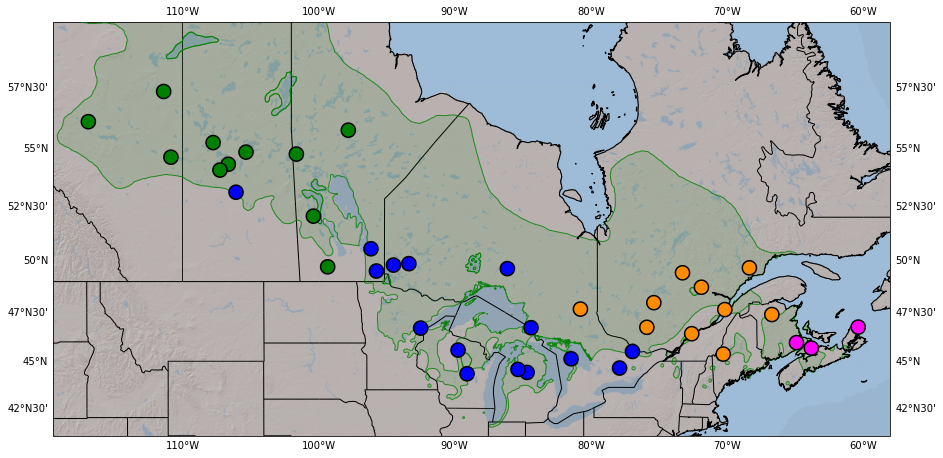

In [29]:
# all jack pine pops
print(ColorText("All jack pine pops").bold())
extent=[-119.5, -58, 41, 60]
figsize=(15,10)
shapefiles=[('green', '/data/projects/pool_seq/environemental_data/shapefiles/jackpine.shp')]
ax = basemap(extent, shapefiles, figsize=figsize)
for row in envdata.index:
    pop,lat,long,color = envdata.loc[row, ['our_id', 'LAT', 'LONG', 'group_color']]
    draw_pie_marker([1,0], long, lat, 200, [color], ax, transform=True)

Fontbrune


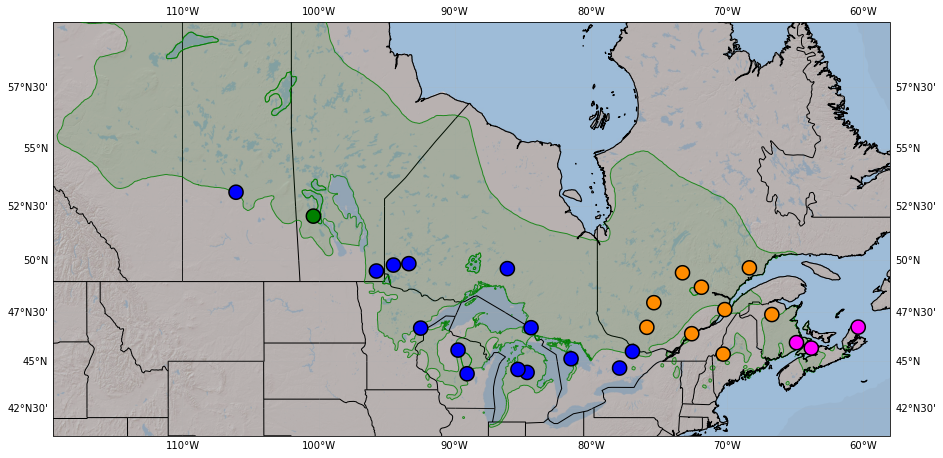

In [30]:
print(ColorText('Fontbrune').bold())
ax = basemap(extent, shapefiles, figsize=figsize)
for row in envdata.index:
    pop,lat,long,color = envdata.loc[row, ['our_id', 'LAT', 'LONG', 'group_color']]
    if pop not in dfs['fontbrune']['our_id'].tolist():
        continue
    draw_pie_marker([1,0], long, lat, 200, [color], ax, transform=True)

Ste-Christine de L'Auvergne


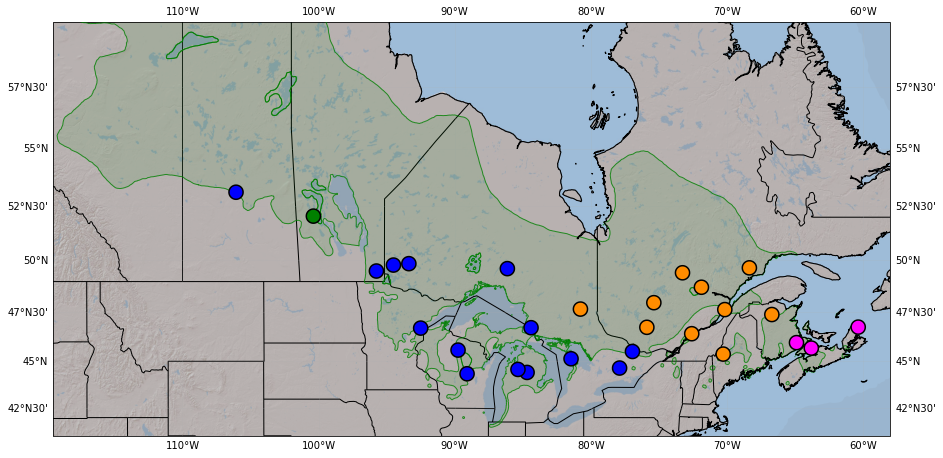

In [31]:
print(ColorText("Ste-Christine de L'Auvergne").bold())
ax = basemap(extent, shapefiles, figsize=figsize)
for row in envdata.index:
    pop,lat,long,color = envdata.loc[row, ['our_id', 'LAT', 'LONG', 'group_color']]
    if pop not in dfs['st-christine']['our_id'].tolist():
        continue
    draw_pie_marker([1,0], long, lat, 200, [color], ax, transform=True)

<a id='doug'></a>
# <center> Douglas-fir </center>

[top](#home)

## clean Vancouver common garden climate data

In [32]:
vandir = '/data/projects/pool_seq/environemental_data/vancouver_data'

In [33]:
# read in file from tongli, take average over two years
van = pd.read_csv(op.join(vandir, 'vancouver_climate-2018-2019.csv'),
                  sep=',')

# fix env labels to match ours (DD_0, DD5, Elevation)
van.columns = [
    col.strip().replace("DD<0", "DD_0").replace("DD>5", "DD5").replace("elev", "Elevation") for col in van.columns
]

# set index
van.index = van['period'].tolist()

# subset columns
van = van[['Lat', 'long'] + envs]

van

,Lat,long,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP
year_2018,49.257,-123.25,81,15.8,336,2510,80,-13.5,35,657,267,1349,11.3,5.3,236,20.1,324,38,85.3,14.8,57,324
year_2019,49.257,-123.25,81,20.3,266,2465,93,-13.5,35,639,257,1039,11.1,5.5,282,19.2,317,34,68.0,13.7,63,320


In [34]:
# get two-year average
van.loc['two_year_avg'] = np.nan
for env in ['Lat', 'long'] + envs:
    van.loc['two_year_avg', env] = van[env].mean()
van

,Lat,long,Elevation,AHM,CMD,DD5,DD_0,EMT,EXT,Eref,FFP,MAP,MAT,MCMT,MSP,MWMT,NFFD,PAS,SHM,TD,bFFP,eFFP
year_2018,49.257,-123.25,81.0,15.80,336.0,2510.0,80.0,-13.5,35.0,657.0,267.0,1349.0,11.3,5.3,236.0,20.10,324.0,38.0,85.30,14.80,57.0,324.0
year_2019,49.257,-123.25,81.0,20.30,266.0,2465.0,93.0,-13.5,35.0,639.0,257.0,1039.0,11.1,5.5,282.0,19.20,317.0,34.0,68.00,13.70,63.0,320.0
two_year_avg,49.257,-123.25,81.0,18.05,301.0,2487.5,86.5,-13.5,35.0,648.0,262.0,1194.0,11.2,5.4,259.0,19.65,320.5,36.0,76.65,14.25,60.0,322.0


In [35]:
# save
van.to_csv(op.join(vandir, 'vancouver_climate-2018-2019_USING.txt'),
           sep='\t',
           index=True)

In [36]:
# write README

README = op.join(vandir, 'README')

with open(README, 'w') as readme:
    readme.write('''Brandon Lind July 2, 2021
the csv files are from Tongli, the USING file is CoAdapTree envs and a two-year average.''')

read(README)

['Brandon Lind July 2, 2021',
 'the csv files are from Tongli, the USING file is CoAdapTree envs and a two-year average.']